# Lab 使用FAST角点检测算法提取图像的角点
# 01：OpenCV FAST

## 检查实验所用的图片 
我们首先导入OpenCV-Python库用作图像处理（Sobel），matplotlib库用作绘图。

In [16]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

首先将src.txt中的数据转换为图像并保存为src.png,我们可以通过`imread`方法读取png格式的图片，原图是一张128x128大小的三通道的图片。

In [18]:
img = cv2.imread("./src.png")
print("原始图像尺寸：{}".format(img.shape))

原始图像尺寸：(962, 1920, 3)


通过`imshow`方法进行图片显示。

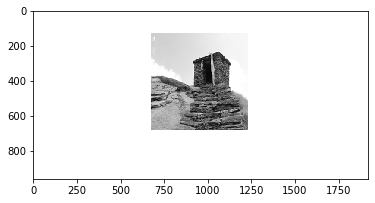

In [19]:
plt.imshow(img[:,:,::-1])

golden图像尺寸：(221, 302, 3)


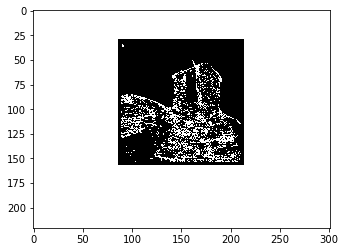

In [32]:
img3 = cv2.imread("./dst.png")
print("golden图像尺寸：{}".format(img3.shape))
plt.imshow(img3[:,:,::-1])

### RGB图转灰度图
将RGB图像转为灰度图，我们可以直观的看到数据维度的变化。

In [23]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print("灰度图尺寸：{}".format(gray.shape))

灰度图尺寸：(962, 1920)


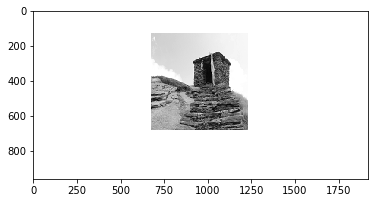

In [24]:
plt.imshow(gray,cmap='gray')

### 使用FAST角点检测算法提取图像的角点
我们可以使用使用FAST角点检测算法提取图像的角点

耗时：0.5766069889068604s


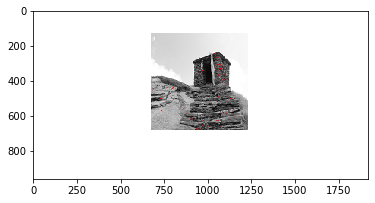

In [28]:
import time

start_time = time.time()

# sobel_x =cv2.Sobel(gray,cv2.CV_8U ,1,0)
# sobel_y = cv2.Sobel(gray,cv2.CV_8U ,0,1)
# sobel_res = np.clip(sobel_x + sobel_y, 0, 255)
# 定义一个fast算法的模型
fast = cv2.FastFeatureDetector_create(threshold=20)

# 进行检测
kps = fast.detect(gray)

# 画出角点
img2 = cv2.drawKeypoints(image=gray, keypoints=kps, outImage=None, color=(255, 0, 0))
plt.imshow(img2)


end_time = time.time()

print("耗时：{}s".format(end_time - start_time))

# 02:  Hardware FAST
## 直接调用方式

### 载入Overlay

将硬件设计部署到板卡上，根据图片尺寸分配内存，并将图像复制到对应位置。

In [ ]:
from pynq import Overlay, allocate

overlay = Overlay("./overlay/fast.bit")

fast = overlay.fast_0

In [71]:
# allocate memory
rows, cols= gray.shape
input_buffer = allocate(shape=(rows*cols,), dtype='u1')
output_buffer = allocate(shape=(rows*cols,), dtype='u1')

# input
gray_new = np.uint8(gray)
np.copyto(input_buffer, gray_new.flatten())

### 写入参数
在IP上写入值时，我们可以像Lab1一样根据HLS给出的IP Driver Source Code直接在对应位置写入：

In [72]:
fast.write(0x10, rows)
fast.write(0x18, cols)

由于提供了`fast.hwh`文件，`fast`对象已经包含了Register Map并将其暴露出来，我们可以直接打印查看各寄存器的信息：

In [73]:
fast.register_map

RegisterMap {
  CTRL = Register(AP_START=0, AP_DONE=0, AP_IDLE=1, AP_READY=0, RESERVED_1=0, AUTO_RESTART=0, RESERVED_2=0, INTERRUPT=0, RESERVED_3=0),
  GIER = Register(Enable=0, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=0, CHAN1_INT_EN=0, RESERVED_0=0),
  IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED_0=0),
  rows = Register(rows=write-only),
  cols = Register(cols=write-only)
}

我们也可以直接在Register Map中与其交互，而不需要去手动输入对应的地址：

In [74]:
fast.register_map.rows = rows
fast.register_map.cols = cols

### 启动IP

将IP中的DMA对象提取出来。

In [75]:
dma = overlay.axi_dma_0

FAST IP 使用了AXI Stream的接口格式。
- 我们需要调用DMA读取输入缓冲，并将数据发送到AXI Stream Master
- 之后，DMA应从AXI Stream Slave中将结果写回到输出缓冲中
- `wait`语句确保了DMA的处理操作已经完成

In [76]:
import time

fast.register_map.CTRL.AP_START = 1

start_time = time.time()

dma.sendchannel.transfer(input_buffer)
dma.recvchannel.transfer(output_buffer)
dma.sendchannel.wait() # wait for send channel
dma.recvchannel.wait() # wait for recv channel

end_time = time.time()

print("耗时：{}s".format(end_time - start_time))

耗时：0.011716842651367188s


将结果进行可视化。

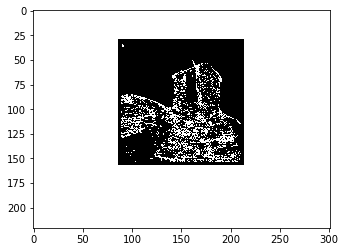

In [33]:
plt.imshow(output_buffer.reshape(rows, cols),cmap='gray')